<h1 align="center"> Image Captioning With Attention</h1>

In this notebook you will teach network to use attention during captioning images.

Here is what we need to do:
1. Take pretrained VGG19 to build feature vectors for positions of images.
2. Stack LSTM with attention on top of that.
3. Train the model, draw attention maps.

This assignment is based on Alexander Panin's captioning assignment (https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework04/homework04_basic_part2_image_captioning.ipynb) and on the paper "Show, Attend and Tell" (https://arxiv.org/abs/1502.03044).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import json

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tqdm import tqdm
import h5py

In [5]:
# you may need to install h5py, tqdm
#!pip install h5py tqdm
import sys
!{sys.executable} -m pip install h5py tqdm

## Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained VGG19 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py).

The whole process takes anywhere between a day on CPU and 30min on 1x GeForce GTX 1060. If you want to play with that yourself, [you're welcome](https://github.com/nadiinchi/dl_labs/blob/master/ht_attention_preprocess_data.ipynb).

Please either download data from [here](https://yadi.sk/d/KGh1SngBWH4stg) or generate it manually using the above script.

In [7]:
!cp -r /content/drive/My\ Drive/ht_attention/data /content

cp: error reading '/content/drive/My Drive/ht_attention/data/img_codes.hdf5': Operation canceled


In [10]:
import subprocess
  
yadiskLink = "https://yadi.sk/d/KGh1SngBWH4stg"

command = 'curl ' + '"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key=' + yadiskLink + '&path=/img_codes.hdf5"'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
(out, err) = process.communicate()

wgetLink = out.decode().split(',')[0][8:]
wgetCommand = 'wget ' + wgetLink + ' -O img_codes.hdf5'
print("Downloading img_codes.hdf5 ...")
process = subprocess.Popen(wgetCommand, stdin=subprocess.PIPE, shell=True)
process.stdin.write('e'.encode())
process.wait()

0

In [6]:
f = h5py.File('img_codes.hdf5', 'r')
img_codes = f['data']

OSError: Unable to open file (unable to open file: name = 'img_codes.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [0]:
captions = json.load(open('/content/drive/My Drive/ht_attention/data/captions_tokenized.json'))

In [7]:
print("Each image code is a 512x9x9-unit tensor [ shape: %s x %s ]" % (str(len(img_codes)), str(img_codes[0].shape)))
print(img_codes[0][:3].round(2), end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 512x9x9-unit tensor [ shape: 118287 x (512, 9, 9) ]
[[[0.   0.   0.   0.   0.07 0.69 0.   0.   0.  ]
  [0.   0.24 0.   0.   0.63 1.94 1.21 0.72 0.46]
  [0.77 0.76 0.   0.   0.   0.88 1.65 2.37 1.14]
  [0.21 0.   0.   0.   2.8  3.3  2.93 6.29 3.48]
  [0.   0.   0.   0.   3.29 3.81 2.24 2.76 0.01]
  [0.   0.   0.   1.18 0.32 0.08 0.   0.   0.  ]
  [1.02 1.76 0.89 1.77 0.   0.   0.   0.   0.  ]
  [0.   1.36 0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.09 0.3  0.  ]]

 [[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.17 0.   0.   0.   0.   0.  ]
  [0.   0.95 0.   0.   0.   0.   0.   0.   0.  ]
  [0.34 1.5  0.   0.   0.36 0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.23 0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.52 0.   0.   0.  ]
  [0.   0.34 0.   0.   0.   0.   0.86 0.34 0.  ]
  [0.   0.47 0.26 0.41 0.   0.   1.08 0.38 0.  ]]

 [[1.09 3.03 2.15 0.65 0.   0.   1.06 0.2

As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            word_counts[word] += 1

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,  162,  199, 1957,   74,   35,   18,  769,   64,   27,    4,
         373, 1427,   14,    2],
       [   1,    4,   99,   21, 1957, 3275,  160,   63,  468,   30,   14,
           2,    3,    3,    3],
       [   1,  149, 1957,   35, 2001,    6,    4, 1556,  779,    2,    3,
           3,    3,    3,    3],
       [   1, 2445,  199, 1957,   35,    4, 1052,    9,    4, 1392, 1015,
          14,    2,    3,    3],
       [   1,   99,   21,  199, 1957,   35,    4, 1052, 1785,    2,    3,
           3,    3,    3,    3]], dtype=int32)

## Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on the features from the convolutional part. 

We'll unbox the inception net later to save memory, for now just pretend that it's available.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

### Attention

There are $K$ objects that you can pay attention to.
Each object is characterized by the key $k_i$ and the value $v_i$.
The attention layer proceeds queries.
For the query $q$, the layer returns a weighted sum of the values of the objects, with weights proportional to the degree of key matching the query:
$$w_i = \frac{\exp(score(q, k_i))}{\sum_{j=1}^K\exp(score(q, k_j))}$$
$$a = \sum_{i=1}^K w_i v_i$$

Here we use $score(q, k) = \frac{q^Tk}{\sqrt{dim(k)}}$, where $dim(k)$ is the dimensionality of the key (which also equals the dimensionality of the query).
For more information see the paper Vaswani et al. "Attention Is All You Need", 2017.

_Hint:_ It is recommended to pay attention to the function torch.bmm, it may be useful below.

#### Score function layer

In [0]:
class ScaledDotProductScore(nn.Module):
    """
    Vaswani et al. "Attention Is All You Need", 2017.
    """
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys):
        """
        queries:  [batch_size x num_queries x dim]
        keys:     [batch_size x num_objects x dim]
        Returns a tensor of scores with shape [batch_size x num_queries x num_objects].
        """
        result = torch.bmm(queries, keys.transpose(1, 2)) / (keys.shape[2])**0.5
        return result

Test for ScaledDotProductScore

In [15]:
q = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0],
]], dtype=torch.float32)
o = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
]], dtype=torch.float32)
print(ScaledDotProductScore()(q, o))

tensor([[[0.4472, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4472, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])


#### Attention layer

In [0]:
class Attention(nn.Module):
    def __init__(self, scorer):
        super().__init__()
        self.scorer = scorer

    def forward(self, queries, keys, values):
        """
        queries:         [batch_size x num_queries x query_feature_dim]
        keys:            [batch_size x num_objects x key_feature_dim]
        values:          [batch_size x num_objects x obj_feature_dim]
        Returns matrix of responses for queries with shape [batch_size x num_queries x obj_feature_dim].
        Saves detached weights as self.attention_map.
        """
        scores = self.scorer(queries, keys)
        weights = F.softmax(scores, dim=2)
        self.attention_map = weights
        result = torch.bmm(weights, values) 
        return result

Tests for Attention layer

In [0]:
attn = Attention(ScaledDotProductScore())

In [0]:
q = torch.randn(2, 3, 5)
k = torch.randn(2, 4, 5)
v = torch.randn(2, 4, 7)
assert attn(q, k, v).shape == (2, 3, 7)

In [0]:
q = torch.tensor([[
    [0.01],
    [1],
    [100],
]], dtype=torch.float32)
o = torch.tensor([[
    [-1],
    [0],
    [1],
]], dtype=torch.float32) * 1000
a = attn(q, o, o)
assert torch.isnan(attn.attention_map).sum() == 0
assert torch.isnan(a).sum() == 0

In [20]:
q = torch.tensor([[
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
k = torch.tensor([[
    [0, 0],
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
v = torch.tensor([[
    [0],
    [1],
    [2],
]], dtype=torch.float32)
a = attn(q, k, v)
print('Attention map:\n', attn.attention_map)
print('Responses:\n', a)

Attention map:
 tensor([[[0.2483, 0.5035, 0.2483],
         [0.2483, 0.2483, 0.5035]]])
Responses:
 tensor([[[1.0000],
         [1.2552]]])


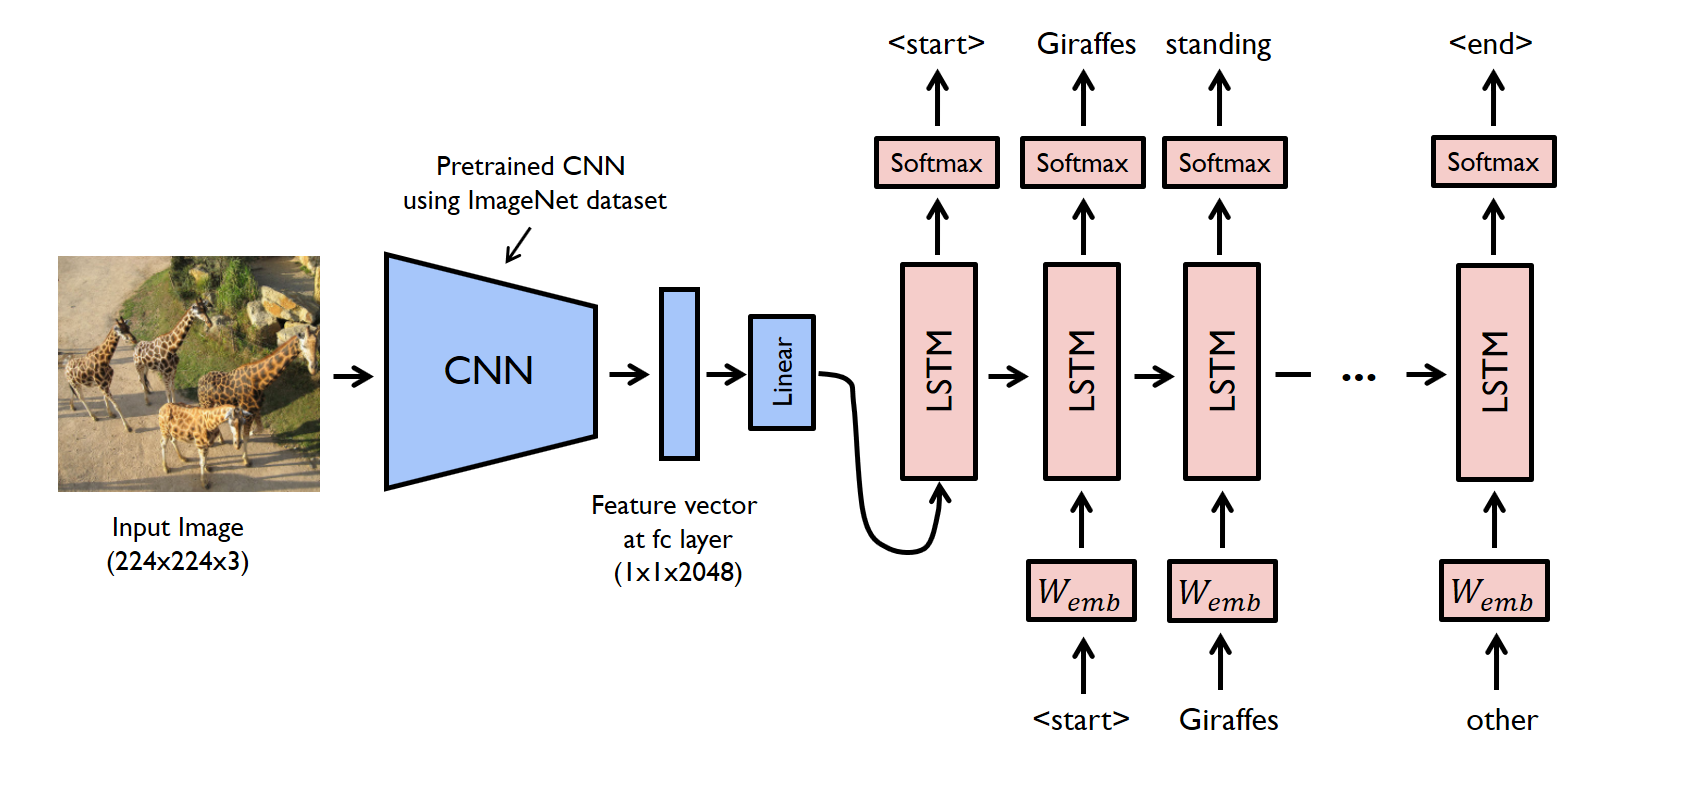

In [0]:
from IPython.display import Image
Image(filename='D:\\image_capturing\\scheme.png')

### Language model

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_channels=512):
        """ A recurrent 'head' network for image captioning. Read scheme below. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_channels, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_channels, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # attention: create attention over image spatial positions
        # The query is previous lstm hidden state, the keys are transformed cnn features,
        # the values are cnn features
        self.attention = Attention(ScaledDotProductScore())
        
        # attention: create transform from cnn features to the keys
        # Hint: one linear layer shoud work
        # Hint: the dimensionality of keys should be lstm_units as lstm
        #       hidden state is the attention query
        self.cnn_to_attn_key = nn.Linear(cnn_channels, lstm_units)
                
        # lstm: create a recurrent core of your network. Use LSTMCell
        self.lstm = nn.LSTMCell(emb_size+cnn_channels, lstm_units)

        # create logits: MLP that takes attention response, lstm hidden state
        # and the previous word embedding as an input and computes one number per token
        # Hint: I used an architecture with one hidden layer, but you may try deeper ones
        self.logits_mlp = nn.Sequential(
            nn.Linear(cnn_channels+lstm_units+emb_size, n_tokens//2),
            nn.ReLU(),
            nn.Linear(n_tokens//2, n_tokens))
        
    def forward(self, image_features, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_features: torch tensor containing VGG features for each position.
                               shape: [batch, cnn_channels, width * height]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_features.mean(2))
        initial_hid = self.cnn_to_h0(image_features.mean(2))
        
        image_features = image_features.transpose(1, 2)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. In the recurrent loop over tokens:
        #   2.1. transform image vectors to the keys for attention
        #   2.2. use previous lstm state as an attention query and image vectors as values
        #   2.3. apply attention to obtain context vector
        #   2.4. store attention map
        #   2.5. feed lstm with current token embedding concatenated with context vector
        #   2.6. update lstm hidden and cell vectors
        #   2.7. store current lstm hidden state, attention response, and the previous word embedding
        # reccurent_out should be lstm hidden state sequence
        # of shape [batch, caption_length, lstm_units + cnn_channels + emb_size]
        # attention_map should be attention maps sequence
        # of shape [batch, caption_length, width * height]
        
        cell = initial_cell
        hid = initial_hid
        
        hids, context_vectors, maps = [], [], []
            
        keys = self.cnn_to_attn_key(image_features)
        
        caption_length = captions_ix.shape[1]
        for i in range(caption_length):
            token_emb = captions_emb[:, i, :]
            context_vector = self.attention(hid.unsqueeze(1), keys, image_features)
            maps.append(self.attention.attention_map)
            hid, cell = self.lstm(torch.cat([context_vector.squeeze(1), token_emb], dim=1), (hid, cell))
            hids.append(hid.unsqueeze(1))
            context_vectors.append(context_vector)
        hidden_states = torch.cat(hids, dim=1)
        att_response = torch.cat(context_vectors, dim=1)
        
        reccurent_out = torch.cat([hidden_states, att_response, captions_emb], dim=2)
        attention_map = torch.cat(maps, dim=1)
        
        # compute logits for next token probabilities
        # based on the stored in (2.7) values (reccurent_out)
        logits = self.logits_mlp(reccurent_out)
        
        # return logits and attention maps from (2.4)
        return logits, attention_map

In [0]:
network = CaptionNet(n_tokens)

In [40]:
dummy_img_vec = torch.randn(len(captions[0]), 512, 81)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits, dummy_attention_map = network.forward(dummy_img_vec, dummy_capt_ix)

print('logits shape:', dummy_logits.shape)
print('attention map shape:', dummy_attention_map.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)
assert dummy_attention_map.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], 81)

logits shape: torch.Size([5, 31, 10403])
attention map shape: torch.Size([5, 31, 81])


#### Train loss function

In [0]:
def compute_loss(network, image_features, captions_ix):
    """
    :param image_features: torch tensor containing VGG features. shape: [batch, cnn_channels, width * height]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones plus 
              attention regularizer. Scalar float tensor
    """
    
    if next(network.parameters()).is_cuda:
        image_features, captions_ix = image_features.cuda(), captions_ix.cuda()
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions, attnetion map and gates for captions_ix_next
    logits_for_next, attention_map = network.forward(image_features, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    CELoss = nn.CrossEntropyLoss()
    mask = (captions_ix_next != pad_ix)
    loss = CELoss(logits_for_next[mask], captions_ix_next[mask])

    # the regularizer for attention - this one requires the attention over each position to sum up to 1,
    # i. e. to look at the whole image during sentence generation process
    mask = (captions_ix_inp != pad_ix)
    masked_attention_map = attention_map * mask[:, :, None].float()
    regularizer = ((1 - masked_attention_map.sum(1)) ** 2).mean()
    
    return loss + regularizer

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.detach().cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

#### Optimizer
Create ~~adam~~ your favorite optimizer for the network.

In [0]:
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

# Training

* First make train/val split without extra memory usage
* Implement the batch generator
* Than train the network as usual

In [0]:
from torch.utils.data import Dataset

class IdxDataset(Dataset):
    def __init__(self, dataset, idx):
        self.dataset = dataset
        self.idx = idx
    
    def __len__(self):
        return len(self.idx)
        
    def __getitem__(self, idx):
        return self.dataset[self.idx[idx]]

In [0]:
captions = np.array(captions)

np.random.seed(42)
perm = np.random.permutation(len(img_codes))
threshold = round(len(img_codes) * 0.1)
train_img_idx, val_img_idx = perm[threshold:], perm[: threshold]

train_img_idx.sort()
val_img_idx.sort()
train_img_codes = IdxDataset(img_codes, train_img_idx)
val_img_codes = IdxDataset(img_codes, val_img_idx)
train_captions = IdxDataset(captions, train_img_idx)
val_captions = IdxDataset(captions, val_img_idx)

In [0]:
from random import choice

last_batch_end = {}

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample sequential numbers for image/caption indicies (for trainign speed up)
    global last_batch_end
    random_image_ix = np.arange(batch_size, dtype='int') + last_batch_end.get(len(img_codes), 0)
    last_batch_end[len(img_codes)] = last_batch_end.get(len(img_codes), 0) + batch_size
    if last_batch_end[len(img_codes)] + batch_size >= len(img_codes):
        last_batch_end[len(img_codes)] = 0
    
    #get images
    batch_images = np.vstack([img_codes[i][None] for i in random_image_ix])
    batch_images = batch_images.reshape(batch_images.shape[0], batch_images.shape[1], -1)
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [47]:
generate_batch(img_codes, captions, 3)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0941, 0.2962, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0764, 0.3785, 0.0000],
          [1.0881, 3.0323, 2.1466,  ..., 0.9595, 1.1179, 0.9478],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0711,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.1465, 1.6479, 1.6033]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3930, 0.9311],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=3.5~3.7

In [0]:
batch_size = 64  # adjust me
n_epochs = 64    # adjust me
n_batches_per_epoch = 64  # adjust me
n_validation_batches = 8  # how many batches are used for validation after each epoch

In [49]:
from tqdm import tqdm

for epoch in range(n_epochs):
    if torch.cuda.is_available():
        network = network.cuda()
   
    train_loss=0
    network.train(True)
    with tqdm(range(n_batches_per_epoch)) as iterator:
        for _ in iterator:
            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
            # clear old gradients; do a backward pass to get new gradients; then train with opt
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
        
            train_loss += float(loss_t)
    train_loss /= n_batches_per_epoch
        
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += float(loss_t)
    val_loss /= n_validation_batches
    
    if torch.cuda.is_available():
        network = network.cpu()

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss), flush=True)

print("Finished!")

100%|██████████| 64/64 [00:09<00:00,  6.93it/s]



Epoch: 0, train loss: 5.528654225170612, val loss: 4.809364020824432


100%|██████████| 64/64 [00:09<00:00,  7.21it/s]



Epoch: 1, train loss: 4.720409490168095, val loss: 4.59466940164566


100%|██████████| 64/64 [00:09<00:00,  6.89it/s]



Epoch: 2, train loss: 4.556191481649876, val loss: 4.506549775600433


100%|██████████| 64/64 [00:09<00:00,  6.56it/s]



Epoch: 3, train loss: 4.426277436316013, val loss: 4.45092499256134


100%|██████████| 64/64 [00:08<00:00,  7.29it/s]



Epoch: 4, train loss: 4.338850073516369, val loss: 4.29881164431572


100%|██████████| 64/64 [00:09<00:00,  6.25it/s]



Epoch: 5, train loss: 4.295461937785149, val loss: 4.284202039241791


100%|██████████| 64/64 [00:09<00:00,  7.12it/s]



Epoch: 6, train loss: 4.27486764639616, val loss: 4.3354750871658325


100%|██████████| 64/64 [00:09<00:00,  6.57it/s]



Epoch: 7, train loss: 4.213478021323681, val loss: 4.168803691864014


100%|██████████| 64/64 [00:08<00:00,  6.61it/s]



Epoch: 8, train loss: 4.1894948072731495, val loss: 4.191327333450317


100%|██████████| 64/64 [00:08<00:00,  6.93it/s]



Epoch: 9, train loss: 4.113275207579136, val loss: 4.180737376213074


100%|██████████| 64/64 [00:08<00:00,  6.16it/s]



Epoch: 10, train loss: 4.101450126618147, val loss: 4.146364271640778


100%|██████████| 64/64 [00:08<00:00,  7.14it/s]



Epoch: 11, train loss: 4.114214438945055, val loss: 3.99814373254776


100%|██████████| 64/64 [00:09<00:00,  6.98it/s]



Epoch: 12, train loss: 4.052806455641985, val loss: 3.9882932007312775


100%|██████████| 64/64 [00:09<00:00,  7.23it/s]



Epoch: 13, train loss: 4.019325144588947, val loss: 4.002518653869629


100%|██████████| 64/64 [00:08<00:00,  7.29it/s]



Epoch: 14, train loss: 4.014383848756552, val loss: 4.0022207498550415


100%|██████████| 64/64 [00:08<00:00,  7.54it/s]



Epoch: 15, train loss: 3.996279288083315, val loss: 4.076944559812546


100%|██████████| 64/64 [00:08<00:00,  7.51it/s]



Epoch: 16, train loss: 3.9364155121147633, val loss: 4.026938647031784


100%|██████████| 64/64 [00:08<00:00,  7.21it/s]



Epoch: 17, train loss: 3.9918196499347687, val loss: 3.8505595326423645


100%|██████████| 64/64 [00:08<00:00,  6.33it/s]



Epoch: 18, train loss: 3.985850915312767, val loss: 3.9662462770938873


100%|██████████| 64/64 [00:08<00:00,  7.09it/s]



Epoch: 19, train loss: 3.941640179604292, val loss: 3.961883693933487


100%|██████████| 64/64 [00:08<00:00,  7.07it/s]



Epoch: 20, train loss: 3.9100404642522335, val loss: 3.912203162908554


100%|██████████| 64/64 [00:08<00:00,  7.37it/s]



Epoch: 21, train loss: 3.945813301950693, val loss: 3.8197490572929382


100%|██████████| 64/64 [00:09<00:00,  6.91it/s]



Epoch: 22, train loss: 3.8657659143209457, val loss: 3.8562115728855133


100%|██████████| 64/64 [00:08<00:00,  6.78it/s]



Epoch: 23, train loss: 3.8452730290591717, val loss: 3.9424125850200653


100%|██████████| 64/64 [00:08<00:00,  7.57it/s]



Epoch: 24, train loss: 3.85628292709589, val loss: 3.847123235464096


100%|██████████| 64/64 [00:08<00:00,  6.84it/s]



Epoch: 25, train loss: 3.829239584505558, val loss: 3.908681094646454


100%|██████████| 64/64 [00:08<00:00,  8.01it/s]



Epoch: 26, train loss: 3.8317228108644485, val loss: 3.9487067461013794


100%|██████████| 64/64 [00:08<00:00,  7.87it/s]



Epoch: 27, train loss: 3.807806294411421, val loss: 3.8305184841156006


100%|██████████| 64/64 [00:08<00:00,  7.07it/s]



Epoch: 28, train loss: 3.8181663155555725, val loss: 3.8040872514247894


100%|██████████| 64/64 [00:08<00:00,  7.98it/s]



Epoch: 29, train loss: 3.7557933256030083, val loss: 3.8151856064796448


100%|██████████| 64/64 [00:08<00:00,  7.26it/s]



Epoch: 30, train loss: 3.7657318376004696, val loss: 3.7778050899505615


100%|██████████| 64/64 [00:08<00:00,  7.35it/s]



Epoch: 31, train loss: 3.779304798692465, val loss: 3.802003026008606


100%|██████████| 64/64 [00:08<00:00,  7.22it/s]



Epoch: 32, train loss: 3.770441632717848, val loss: 3.779490143060684


100%|██████████| 64/64 [00:09<00:00,  7.33it/s]



Epoch: 33, train loss: 3.75461982190609, val loss: 3.7893075942993164


100%|██████████| 64/64 [00:08<00:00,  7.46it/s]



Epoch: 34, train loss: 3.7602854035794735, val loss: 3.8310119211673737


100%|██████████| 64/64 [00:08<00:00,  7.26it/s]



Epoch: 35, train loss: 3.749875370413065, val loss: 3.754676789045334


100%|██████████| 64/64 [00:08<00:00,  6.73it/s]



Epoch: 36, train loss: 3.7557364515960217, val loss: 3.783150762319565


100%|██████████| 64/64 [00:08<00:00,  7.15it/s]



Epoch: 37, train loss: 3.7221257239580154, val loss: 3.7570198476314545


100%|██████████| 64/64 [00:09<00:00,  6.66it/s]



Epoch: 38, train loss: 3.6952438913285732, val loss: 3.7232376039028168


100%|██████████| 64/64 [00:09<00:00,  6.71it/s]



Epoch: 39, train loss: 3.6815025731921196, val loss: 3.8147510290145874


100%|██████████| 64/64 [00:09<00:00,  7.21it/s]



Epoch: 40, train loss: 3.7192208245396614, val loss: 3.6611179411411285


100%|██████████| 64/64 [00:09<00:00,  6.92it/s]



Epoch: 41, train loss: 3.712672844529152, val loss: 3.756138503551483


100%|██████████| 64/64 [00:09<00:00,  6.40it/s]



Epoch: 42, train loss: 3.642171159386635, val loss: 3.7776403427124023


100%|██████████| 64/64 [00:09<00:00,  7.18it/s]



Epoch: 43, train loss: 3.6729195564985275, val loss: 3.6434613466262817


100%|██████████| 64/64 [00:09<00:00,  6.16it/s]



Epoch: 44, train loss: 3.7014021687209606, val loss: 3.674773931503296


100%|██████████| 64/64 [00:09<00:00,  6.93it/s]



Epoch: 45, train loss: 3.689910627901554, val loss: 3.7335031628608704


100%|██████████| 64/64 [00:09<00:00,  6.70it/s]



Epoch: 46, train loss: 3.6779243126511574, val loss: 3.6811024248600006


100%|██████████| 64/64 [00:09<00:00,  6.92it/s]



Epoch: 47, train loss: 3.684210631996393, val loss: 3.664663553237915


100%|██████████| 64/64 [00:09<00:00,  7.15it/s]



Epoch: 48, train loss: 3.662396229803562, val loss: 3.7469777166843414


100%|██████████| 64/64 [00:09<00:00,  6.42it/s]



Epoch: 49, train loss: 3.6466460339725018, val loss: 3.78901869058609


100%|██████████| 64/64 [00:09<00:00,  6.93it/s]



Epoch: 50, train loss: 3.6144843958318233, val loss: 3.6771866381168365


100%|██████████| 64/64 [00:09<00:00,  6.67it/s]



Epoch: 51, train loss: 3.604892175644636, val loss: 3.745471715927124


100%|██████████| 64/64 [00:09<00:00,  7.04it/s]



Epoch: 52, train loss: 3.6486654952168465, val loss: 3.741835832595825


100%|██████████| 64/64 [00:09<00:00,  6.57it/s]



Epoch: 53, train loss: 3.6122487112879753, val loss: 3.6885785460472107


100%|██████████| 64/64 [00:09<00:00,  7.00it/s]



Epoch: 54, train loss: 3.635180063545704, val loss: 3.5906704366207123


100%|██████████| 64/64 [00:09<00:00,  6.78it/s]



Epoch: 55, train loss: 3.607312686741352, val loss: 3.6739583909511566


100%|██████████| 64/64 [00:09<00:00,  7.46it/s]



Epoch: 56, train loss: 3.606391754001379, val loss: 3.7040054202079773


100%|██████████| 64/64 [00:09<00:00,  6.75it/s]



Epoch: 57, train loss: 3.6145507395267487, val loss: 3.73315367102623


100%|██████████| 64/64 [00:10<00:00,  6.47it/s]



Epoch: 58, train loss: 3.6311619207262993, val loss: 3.629068434238434


100%|██████████| 64/64 [00:09<00:00,  6.83it/s]



Epoch: 59, train loss: 3.5955869667232037, val loss: 3.77204966545105


100%|██████████| 64/64 [00:09<00:00,  7.02it/s]



Epoch: 60, train loss: 3.6241542920470238, val loss: 3.630001187324524


100%|██████████| 64/64 [00:09<00:00,  7.02it/s]



Epoch: 61, train loss: 3.5579468086361885, val loss: 3.746401160955429


100%|██████████| 64/64 [00:09<00:00,  7.57it/s]



Epoch: 62, train loss: 3.5881131924688816, val loss: 3.7573475539684296


100%|██████████| 64/64 [00:09<00:00,  6.64it/s]



Epoch: 63, train loss: 3.5961343199014664, val loss: 3.6149624586105347
Finished!


### Apply trained model

Let's unpack our pre-trained VGG network and see what our model is capable of.

In [0]:
from torch import nn
import torch.nn.functional as F
from torchvision.models.vgg import VGG, cfgs as VGG_cfgs, make_layers
from warnings import warn
class BeheadedVGG19(VGG):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x_for_attn = x= self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = x = self.classifier(x)
        return x_for_attn, logits
    
features_net = BeheadedVGG19(make_layers(VGG_cfgs['E'], batch_norm=False), init_weights=False)

from torch.utils.model_zoo import load_url
features_net_url = 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
features_net.load_state_dict(load_url(features_net_url))

features_net = features_net.train(False)
if torch.cuda.is_available():
    features_net = features_net.cuda()
features_net = nn.DataParallel(features_net)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_9x9, logits = features_net(image[None])
    caption_prefix = list(caption_prefix)
    
    attention_maps = []
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        input_features = vectors_9x9.view(vectors_9x9.shape[0], vectors_9x9.shape[1], -1)
        if next(network.parameters()).is_cuda:
            input_features, prefix_ix = input_features.cuda(), prefix_ix.cuda()
        else:
            input_features, prefix_ix = input_features.cpu(), prefix_ix.cpu()
        next_word_logits, cur_attention_map = network(input_features, prefix_ix)
        next_word_logits = next_word_logits[0, -1]
        cur_attention_map = cur_attention_map[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().cpu().numpy()
        attention_maps.append(cur_attention_map.detach().cpu())
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break

    return caption_prefix, attention_maps

Here is the code which downloads image, prints different generated captions and visualize attention map.

In [0]:
from matplotlib import pyplot as plt
from skimage.transform import resize
from tempfile import mktemp
from os import remove
%matplotlib inline

# get and preprocess image
def obtain_image(filename=None, url=None):
    if (filename is None and url is None) or (filename is not None and url is not None):
        raise ValueError('You shoud specify either filename or url')
    if url is not None:
        tmpfilename = mktemp()
        !wget {url} -O {tmpfilename} -q
        img = plt.imread(tmpfilename)
        remove(tmpfilename)
    else:
        img = plt.imread(filename)
    img = resize(img, (299, 299), mode='wrap', anti_aliasing=True).astype('float32')
    return img

def show_img(img):
    plt.imshow(img)
    plt.axis('off')

def print_possible_captions(img, num_captions=10, temperature=5.):
    for i in range(num_captions):
        print(' '.join(generate_caption(img, t=temperature)[0][1:-1]))
        
def draw_attention_map(img, caption, attention_map):
    s = 4
    n = len(caption)
    w = 4
    h = n // w + 1
    plt.figure(figsize=(w * s, h * s))
    plt.subplot(h, w, 1)
    plt.imshow(img)
    plt.title('INPUT', fontsize=s * 4)
    plt.axis('off')
    for i, word, attention in zip(range(n), caption, attention_map):
        plt.subplot(h, w, 2 + i)
        attn_map = attention.view(1, 1, 9, 9)
        attn_map = F.interpolate(attn_map, size=(12, 12), mode='nearest')
        attn_map = F.interpolate(attn_map, size=(299, 299), mode='bilinear', align_corners=False)
        attn_map = attn_map[0, 0][:, :, None]
        attn_map = torch.min(attn_map / attn_map.max(), torch.ones_like(attn_map)).numpy()
        plt.imshow(img * attn_map)
        plt.title(word, fontsize=s * 4)
        plt.axis('off')

def process_image(img):
    print_possible_captions(img)
    c, am = generate_caption(img, t=5.)
    draw_attention_map(img, c[1:-1], am)

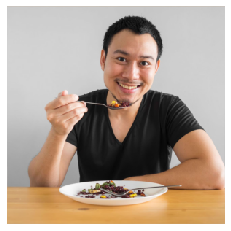

In [53]:
img = obtain_image(url="https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg")
show_img(img)

a man standing on a tennis court holding a racquet .
a man in a suit and tie is on a skateboard .
a man sitting on a bench with a dog on it .
a man is standing in front of a large white car .
a man is standing on a tennis court holding a racquet .
a man standing on a tennis court holding a tennis racket .
a man standing on a tennis court holding a racquet .
a man is standing in a room with a laptop .
a man is standing on a tennis court holding a tennis racket .
a man in a suit and tie is sitting on a bench .


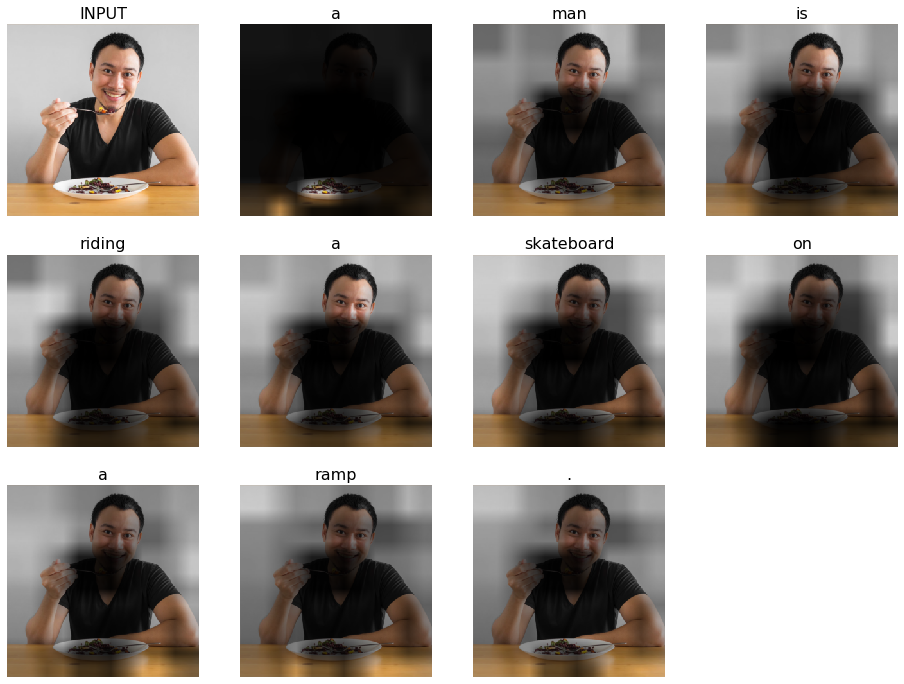

In [54]:
process_image(img)

a man is holding a tennis racquet on a tennis court .
a man is holding a baseball bat on a field .
a man is riding a skateboard down a ramp .
a man in a suit and tie standing in front of a building .
a man with a backpack is standing in front of a building .
a man riding a skateboard on a ramp .
a man is holding a baseball bat in the air .
a man is holding a tennis racquet on a tennis court .
a man is holding a baseball bat in a field .
a man in a suit and tie standing in front of a building .


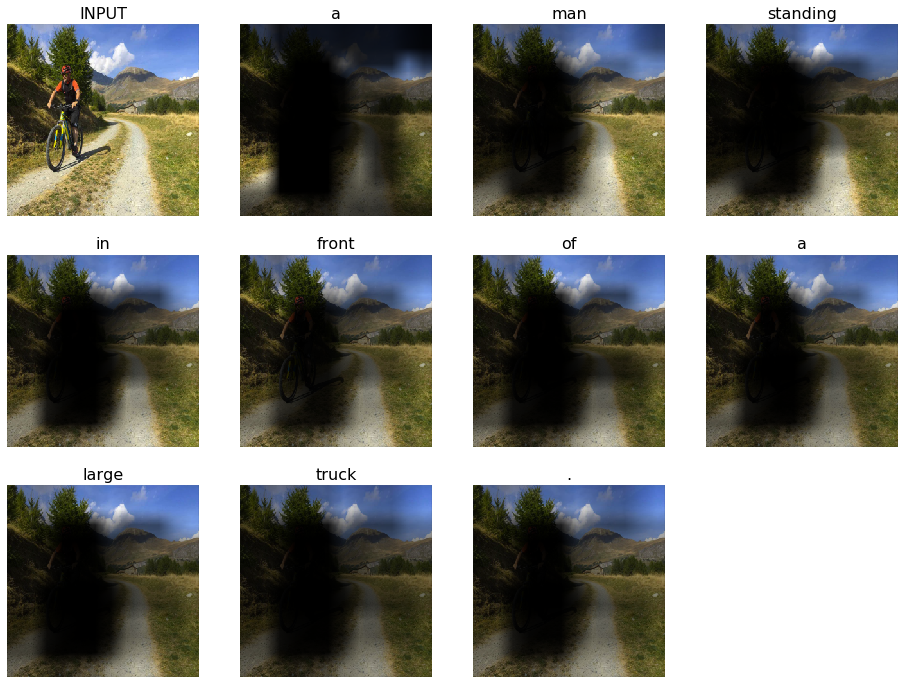

In [44]:
process_image(obtain_image(url="https://www.dimensioneattiva.it/wp-content/uploads/2016/10/Bike5.jpg"))

a man is holding a tennis racket in his hand .
a man riding a skateboard on a ramp .
a man in a suit and tie standing on a skateboard .
a man is standing on a tennis court holding a racquet .
a man is holding a baseball bat at a baseball game .
a man riding a skateboard on top of a ramp .
a man with a helmet on his head
a man holding a tennis racquet on a tennis court .
a man holding a tennis racket in a tennis court .
a man in a suit and tie standing next to a woman .


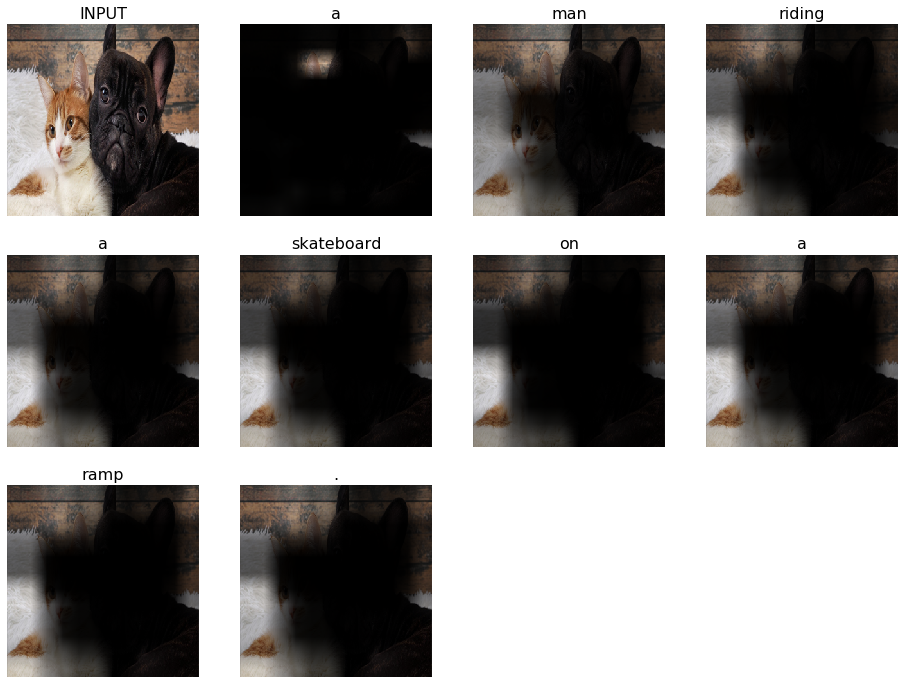

In [55]:
process_image(obtain_image(url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg"))

a man in a suit and tie standing in front of a building .
a man on a skateboard does a trick on a ramp .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in a room .
a man with a tie and a tie .
a man and a woman are playing a video game .
a man in a suit and tie standing next to a woman .
a man is holding a tennis racquet on a tennis court .
a man is sitting on a bench with a dog .
a man in a suit and tie standing in a room .


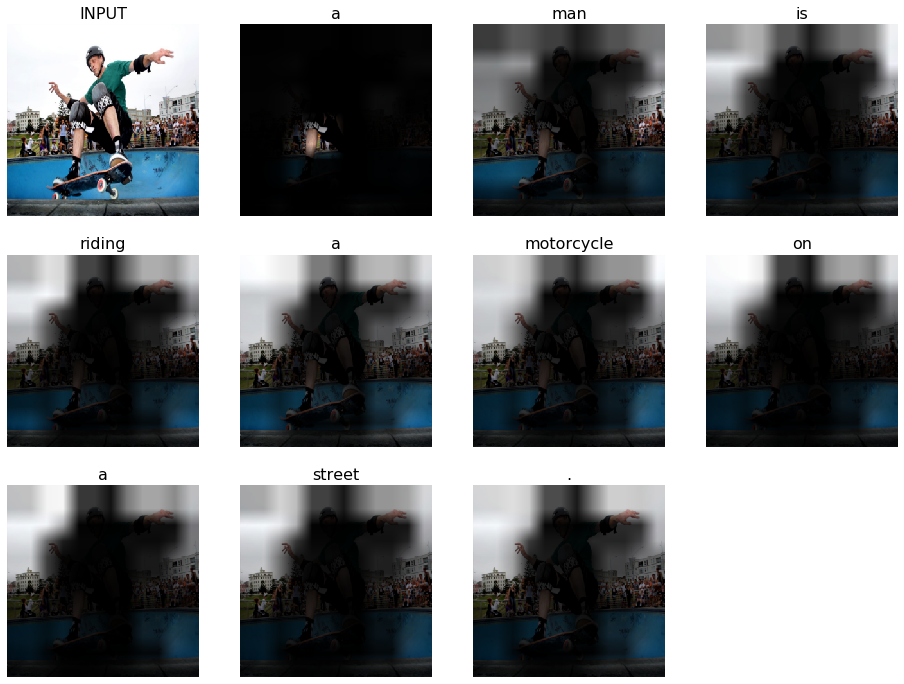

In [46]:
process_image(obtain_image(url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg"))

In [47]:
process_image(obtain_image(filename="/home/oleg/usa00/IMG_20190520_125121.jpg"))

FileNotFoundError: ignored

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [0]:
#apply your network on image sample you found
#
#

### Conclusion
Here is a place for your conclusions, observations, hypotheses, and any other feedback.

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention over the generated part of the sentense.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563